In [1]:
import glob
import pandas as pd
import pyinform
import pprint
import time
import multiprocessing
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
DATA_FILE_DIRECTORY: str = 'C:/STUFF/RESEARCH/TENet/DATA'
MINIMUM_POSTS = 10
FREQUENCY = 'D'

In [6]:
def read_data(data_directory):
    data_files = glob.glob(data_directory)
    print(data_files)
    df_list = []
    for idx, file in enumerate(data_files):
        print(f"Reading {idx + 1} of {len(data_files)} files.\nFile name: {file}")
        df = pd.read_csv(data_files[0], skiprows=6, parse_dates=['Date'])
        df = df[['Date', 'Hashtags', 'Twitter Author ID', 'Author', 'Url']]
        df = df.rename(columns={'Twitter Author ID': 'AuthorID'})
        df_list.append(df)
    return pd.concat(df_list).drop_duplicates()

In [17]:
def find_hashtag(hashtag_list_str, target_hashtags):
    if type(hashtag_list_str) != str:
        return None
    hashtag_list = hashtag_list_str.split(", ")
    print(hashtag_list)
    target_flags = [(lfh in hashtag_list) for lfh in target_hashtags]
    print(target_flags)
    
find_hashtag("#abc, #bbc, #foo, #cool", ['#abc', '#bbc'])

['#abc', '#bbc', '#foo', '#cool']
[True, True]


## Read data

In [8]:
task_start_time = time.time()

# Read all files and populate the global variables
all_data_df = read_data(os.path.join(DATA_FILE_DIRECTORY, "*.csv*"))
start_date = all_data_df['Date'].dt.date.min()
end_date = all_data_df['Date'].dt.date.max()

print(f"Data available from {start_date} to {end_date}")

# add Hashtag column
all_data_df['Hashtag'] = all_data_df.Hashtags.apply(
    lambda x: '#wildfire' if ((type(x) != str) or ('#wildfire' in x.split(", "))) else '#infinitychallenge')
all_data_df.drop(columns=["Hashtags"], inplace=True)
print(all_data_df.head())

print(f"{time.time() - task_start_time} seconds spent on calculating activity.")

['C:/STUFF/RESEARCH/TENet/DATA\\2033703822_TheThreeTopics.csv.zip']
Reading 1 of 1 files.
File name: C:/STUFF/RESEARCH/TENet/DATA\2033703822_TheThreeTopics.csv.zip
Data available from 2021-11-30 to 2022-03-01
                 Date    AuthorID           Author  \
0 2022-03-01 23:46:23  2498932848  berkeleyforests   
1 2022-03-01 23:15:13  3214604043       LarimerOEM   
2 2022-03-01 23:08:47    33319260       joanacasey   
3 2022-03-01 22:53:28  3437976809     RobMooreNRDC   
4 2022-03-01 22:49:30   227400774      ForestryUSA   

                                                 Url    Hashtag  
0  http://twitter.com/berkeleyforests/statuses/14...  #wildfire  
1  http://twitter.com/LarimerOEM/statuses/1498799...  #wildfire  
2  http://twitter.com/joanacasey/statuses/1498797...  #wildfire  
3  http://twitter.com/RobMooreNRDC/statuses/14987...  #wildfire  
4  http://twitter.com/ForestryUSA/statuses/149879...  #wildfire  
0.40912508964538574 seconds spent on calculating activity.


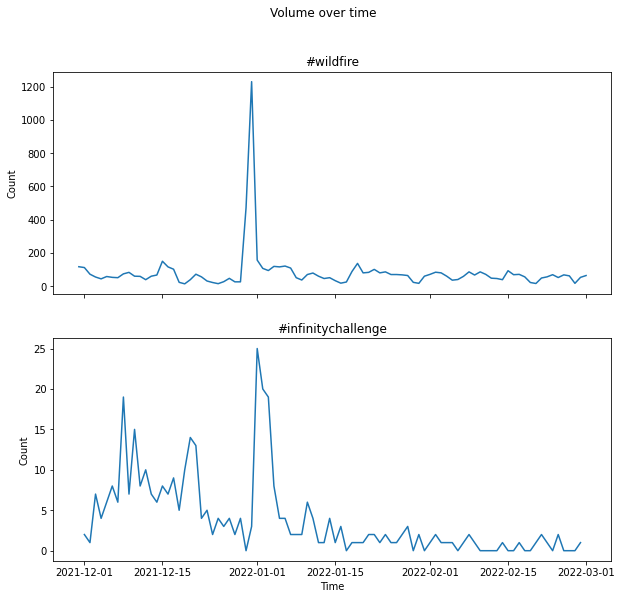

In [102]:
fig, axs = plt.subplots(2,sharex=True,figsize=(10, 9))

axs[0].plot(all_data_df[all_data_df.Hashtag == '#wildfire'].set_index('Date').resample('D').count().iloc[:,0])
axs[0].set_title("#wildfire")
axs[0].set_ylabel("Count")

axs[1].plot(all_data_df[all_data_df.Hashtag == '#infinitychallenge'].set_index('Date').resample('D').count().iloc[:,0])
axs[1].set_title("#infinitychallenge")
axs[1].set_ylabel("Count")

plt.suptitle("Volume over time")
plt.xlabel("Time")
plt.show()



In [103]:
# find high activity authors

task_start_time = time.time()

author_to_num_mentions_dict = all_data_df['AuthorID'].value_counts().to_dict()
high_activity_authors = [a for a in author_to_num_mentions_dict if author_to_num_mentions_dict[a] > MINIMUM_POSTS]
indexed_high_activity_authors = [(i, j) for i, j in enumerate(high_activity_authors)]

print(high_activity_authors)

print(f"{time.time() - task_start_time} seconds spent on calculating activity.")

[58658349, 3111226033, 3301926908, 128128069, 20207761, 884130463878529024, 154902138, 1358718719577489410, 239666710, 1104740466, 763336831295328256, 25144145, 18454808, 250402748, 314024592, 22653760, 1403131600653590528, 14957366, 1136055528273133569, 179261808, 1318962022143254530, 125177569, 1877444256, 1148457028920078336, 262675787, 16309969, 958321766, 48817182, 126075164, 3245582817, 922902086194311168, 400472437, 1163887880, 484265155, 151543424, 326890702, 38833974, 50361094, 74912769, 20295438, 20453796, 1471594463722041344, 587575999, 170554164, 4784417526, 2493306794, 1908515251, 852163986644717568, 1327793130, 81147404, 306243059, 2598357146, 1298648659362373632, 19215993, 2414195305, 910767907377889281, 1089306632016654336, 12837932, 305818642, 2591349990]
0.004997730255126953 seconds spent on calculating activity.


In [ ]:
# calculate author data
results = multiprocess_run_calculate_author_values(high_activity_authors, author_to_num_mentions_dict, all_data_df,
                                                   time_index_series)
time_series_list = [r[1] for r in results]
node_list = [r[0] for r in results]
del results

print(f"{time.time() - task_start_time} seconds spent on resampling the timeseries and setting up node data")
task_start_time = time.time()

In [ ]:






print("Time series list: ", len(time_series_list))
print("Node list: ", len(node_list))

# generate node list file for Gephi
node_list_df = pd.DataFrame(node_list, columns=['Id', 'Label', 'Count'])
node_list_df.to_csv('nodes.csv', index=False)
del node_list_df
del node_list

print(f"{time.time() - task_start_time} seconds spent on writing node list to file.")
task_start_time = time.time()

# the te values calculated for enumerated authors
src_tgt_te = multiprocess_run_calculate_te_edge_list(indexed_high_activity_authors, time_series_list)

print(f"{time.time() - task_start_time} seconds spent on calculating transfer entropy.")
task_start_time = time.time()

# generate edge list file for Gephi
edge_list_df = pd.DataFrame(src_tgt_te, columns=['Source', 'Target', 'TE'])
print(edge_list_df)
edge_list_df['Weight'] = edge_list_df['TE'].apply(lambda x: 1 if x > 0.05 else 0)
max_te = edge_list_df['TE'].max()
edge_list_df['Normalized'] = edge_list_df['TE'].apply(lambda x: x / max_te)
print(edge_list_df)
edge_list_df.to_csv('edges.csv', index=False)

print(f"{time.time() - task_start_time} seconds spent on writing edge list to file.")
task_start_time = time.time()